# Medical MCQ Evaluation using Multiple LLMs

This notebook evaluates the performance of multiple LLMs (Azure OpenAI and Groq models) on medical multiple-choice questions. We'll treat this as a multiclass classification problem and calculate accuracy, precision, recall, and F1 score for each model.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import time
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from openai import AzureOpenAI
from groq import Groq

## 1. Load and Explore the Dataset

In [3]:
# Load the dataset
df = pd.read_csv(r"C:\Users\lenovo\Desktop\LLM_Evaluation\data\processed\MedMCQA_dataset.csv")
df.head()

,question,opa,opb,opc,opd,cop,choice_type,exp,subject_name,topic_name
0,Which of the following is not true for myelina...,Impulse through myelinated fibers is slower th...,Membrane currents are generated at nodes of Ra...,Saltatory conduction of impulses is seen,Local anesthesia is effective only when the ne...,0,multi,NaN,Physiology,NaN
1,Which of the following is not true about glome...,The oncotic pressure of the fluid leaving the ...,Glucose concentration in the capillaries is th...,Constriction of afferent aeriole decreases the...,Hematocrit of the fluid leaving the capillarie...,0,multi,Ans-a. The oncotic pressure of the fluid leavi...,Physiology,NaN
2,A 29 yrs old woman with a pregnancy of 17 week...,No test is required now as her age is below 35...,Ultra sound at this point of time will definit...,Amniotic fluid samples plus chromosomal analys...,blood screening at this point of time will cle...,2,single,NaN,Medicine,NaN
3,Axonal transport is:,Antegrade,Retrograde,Antegrade and retrograde,NaN,2,multi,Fast anterograde (400 mm/day) transport occurs...,Physiology,NaN
4,Low insulin to glucagon ratio is seen in all o...,Glycogen synthesis,Glycogen breakdown,Gluconeogenesis,Ketogenesis,0,multi,Answer- A. Glycogen synthesisLow insulin to gl...,Biochemistry,NaN


In [4]:
# Basic dataset information
print(f"Dataset shape: {df.shape}")
print("\nSubject distribution:")
print(df['subject_name'].value_counts())

# Check for any missing values
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (4183, 10)

Subject distribution:
subject_name
Dental                          1318
Surgery                          369
Pathology                        337
Medicine                         295
Pharmacology                     243
Anatomy                          234
Pediatrics                       234
Gynaecology & Obstetrics         224
Physiology                       171
Biochemistry                     171
Social & Preventive Medicine     129
Microbiology                     122
Radiology                         69
Forensic Medicine                 67
Ophthalmology                     58
ENT                               53
Anaesthesia                       34
Orthopaedics                      20
Skin                              17
Psychiatry                        16
Unknown                            2
Name: count, dtype: int64

Missing values:
question           0
opa                0
opb                0
opc                1
opd               40
cop          

## 2. Set up API Connections

We'll set up connections for both Azure OpenAI and Groq APIs.

In [5]:
from dotenv import load_dotenv
load_dotenv()

# Azure OpenAI configuration
azure_api_key=os.getenv("AZURE_OPENAI_KEY")
azure_api_version= os.getenv("AZURE_OPENAI_VERSION")
azure_endpoint=os.getenv("AZURE_ENDPOINT")
AZURE_DEPLOYMENT_NAME = "gpt-4o-mini"

# Groq API configuration
groq_api_key = os.getenv("GROQ_API_KEY_MAIN")

In [6]:
# Initialize the Azure OpenAI client
azure_client = AzureOpenAI(
    api_key=azure_api_key,
    api_version=azure_api_version,
    base_url=f"{azure_endpoint}/openai/deployments/{AZURE_DEPLOYMENT_NAME}"
)

# Initialize the Groq client
groq_client = Groq(api_key=groq_api_key)

In [7]:
# Define available Groq models
GROQ_MODELS = [
    "llama-3.3-70b-versatile",  # Llama 3 8B
    "mistral-saba-24b", # Llama 3 70B
   "llama-3.1-8b-instant",     # Gemma 7B Instruction Tuned
    "gemma2-9b-it", # Mixtral 8x7B
]

# Define all models for evaluation
MODELS = [
    {"provider": "azure", "name": AZURE_DEPLOYMENT_NAME},
    {"provider": "groq", "name": "llama-3.3-70b-versatile",},
    {"provider": "groq", "name": "mistral-saba-24b"},
    {"provider": "groq", "name": "llama-3.1-8b-instant"},
    {"provider": "groq", "name": "gemma2-9b-it"}
]

## 3. Define Functions for LLM Interaction

In [ ]:
def create_mcq_prompt(question, opt_a, opt_b, opt_c, opt_d):
    """
    Create a formatted prompt for the MCQ question.
    """
    prompt = f"""
Please answer the following medical multiple-choice question. 
Select only one option (A, B, C, or D) that you think is correct.

Question: {question}
A. {opt_a}
B. {opt_b}
C. {opt_c}
D. {opt_d}

Your answer (A, B, C, or D): 
"""
    return prompt

In [9]:
def get_azure_response(prompt, max_retries=3, backoff_factor=2):
    """
    Get response from Azure OpenAI with retry logic for rate limits.
    """
    for retry in range(max_retries):
        try:
            response = azure_client.chat.completions.create(
                model=AZURE_DEPLOYMENT_NAME,
                messages=[
                    {"role": "system", "content": "You are a medical expert taking a multiple-choice exam. Answer only with the letter of your selected option (A, B, C, or D)."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.0,  # Use 0 for deterministic answers
                max_tokens=10  # We only need a short response
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            if retry < max_retries - 1:
                sleep_time = backoff_factor ** retry
                print(f"Error: {e}. Retrying in {sleep_time} seconds...")
                time.sleep(sleep_time)
            else:
                print(f"Failed after {max_retries} retries: {e}")
                return "Error"

In [10]:
def get_groq_response(prompt, model_name, max_retries=3, backoff_factor=2):
    """
    Get response from Groq API with retry logic for rate limits.
    """
    for retry in range(max_retries):
        try:
            response = groq_client.chat.completions.create(
                model=model_name,
                messages=[
                    {"role": "system", "content": "You are a medical expert taking a multiple-choice exam. Answer only with the letter of your selected option (A, B, C, or D)."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.0,  # Use 0 for deterministic answers
                max_tokens=10  # We only need a short response
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            if retry < max_retries - 1:
                sleep_time = backoff_factor ** retry
                print(f"Error: {e}. Retrying in {sleep_time} seconds...")
                # time.sleep(sleep_time)
            else:
                print(f"Failed after {max_retries} retries: {e}")
                return "Error"

In [11]:
def get_model_response(prompt, provider, model_name):
    """
    Get response from the appropriate LLM provider.
    """
    if provider.lower() == "azure":
        return get_azure_response(prompt)
    elif provider.lower() == "groq":
        return get_groq_response(prompt, model_name)
    else:
        return f"Unknown provider: {provider}"

In [12]:
def extract_answer(response):
    """
    Extract the answer letter (A, B, C, or D) from the LLM response.
    """
    # Try to find a single letter answer
    match = re.search(r'\b[A-D]\b', response)
    if match:
        return match.group(0)
    
    # If not found, check if any of A, B, C, D appears in the response
    for option in ['A', 'B', 'C', 'D']:
        if option in response:
            return option
    
    # If no valid option is found
    return "Unknown"

In [13]:
def convert_cop_to_letter(cop):
    """
    Convert the numeric cop (correct option) to letter (A, B, C, D).
    """
    mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
    return mapping.get(cop, "Unknown")

## 4. Test on a Small Sample First

In [14]:
# Test all models on a single question first
sample_question = df.iloc[0]
prompt = create_mcq_prompt(sample_question['question'], sample_question['opa'], sample_question['opb'], sample_question['opc'], sample_question['opd'])
correct_answer = convert_cop_to_letter(sample_question['cop'])

print(f"Question: {sample_question['question']}")
print(f"Correct Answer: {correct_answer}\n")

for model in MODELS:
    provider = model['provider']
    model_name = model['name']
    print(f"Testing {provider} - {model_name}...")
    response = get_model_response(prompt, provider, model_name)
    predicted_answer = extract_answer(response)
    print(f"Response: {response}")
    print(f"Predicted Answer: {predicted_answer}")
    print(f"Correct? {predicted_answer == correct_answer}\n")

Question: Which of the following is not true for myelinated nerve fibers:
Correct Answer: A

Testing azure - gpt-4o-mini...
Response: A
Predicted Answer: A
Correct? True

Testing groq - llama-3.3-70b-versatile...
Response: B is incorrect in the context of the question as
Predicted Answer: B
Correct? False

Testing groq - mistral-saba-24b...
Response: A
Predicted Answer: A
Correct? True

Testing groq - llama-3.1-8b-instant...
Response: A
Predicted Answer: A
Correct? True

Testing groq - gemma2-9b-it...
Response: A
Predicted Answer: A
Correct? True



## 5. Process the Dataset with Multiple Models

Now let's process the dataset using multiple models to compare their performance. We'll select 5 questions from each subject to ensure a balanced evaluation while keeping the total evaluation size manageable.

In [15]:
# Define how many questions to evaluate per subject
QUESTIONS_PER_SUBJECT = 5

# Get the list of all subjects
all_subjects = df['subject_name'].unique()

# Select a stratified sample with equal questions per subject
eval_df = pd.DataFrame()

for subject in all_subjects:
    subject_df = df[df['subject_name'] == subject]
    if len(subject_df) > QUESTIONS_PER_SUBJECT:
        # Sample from this subject
        sampled = subject_df.sample(QUESTIONS_PER_SUBJECT, random_state=42)
        eval_df = pd.concat([eval_df, sampled], ignore_index=True)
    else:
        # Take all questions from this subject if less than our target
        eval_df = pd.concat([eval_df, subject_df], ignore_index=True)

# Calculate the total evaluation size
EVAL_SIZE = len(eval_df)
print(f"Total questions for evaluation: {EVAL_SIZE}")
print(f"Subjects included: {len(eval_df['subject_name'].unique())}")
print("\nSubject distribution:")
print(eval_df['subject_name'].value_counts())

# Dictionary to store results for each model
all_results = {f"{model['provider']}_{model['name']}": [] for model in MODELS}

# Create a progress bar for overall processing
from IPython.display import display, clear_output
import ipywidgets as widgets

# Create a status widget to show current model and question
status_widget = widgets.HTML(value="Not started")
display(status_widget)

# Create overall progress bar
overall_progress = widgets.IntProgress(
    value=0,
    min=0,
    max=len(eval_df) * len(MODELS),
    description='Overall:',
    bar_style='info'
)
display(overall_progress)

# Create model-specific progress bars
model_progress = {}
for model in MODELS:
    model_key = f"{model['provider']}_{model['name']}"
    model_progress[model_key] = widgets.IntProgress(
        value=0,
        min=0,
        max=len(eval_df),
        description=f"{model_key[:15]}...:",
        bar_style='success'
    )
    display(model_progress[model_key])

# Track start time for ETA calculation
start_time = time.time()
processed_count = 0

# Add more delay between API calls to prevent rate limiting
model_delay = {
    'azure': 0.2,  # Azure has higher rate limits
    'groq': 0.3    # Groq might need more delay between calls
}

# Process each question with each model
for idx, row in eval_df.iterrows():
    # Update status with current question
    question_short = row['question'][:50] + "..." if len(row['question']) > 50 else row['question']
    status_widget.value = f"<b>Processing question {processed_count+1}/{len(eval_df)}:</b> {question_short}"
    
    prompt = create_mcq_prompt(row['question'], row['opa'], row['opb'], row['opc'], row['opd'])
    correct_answer = convert_cop_to_letter(row['cop'])
    
    for model in MODELS:
        provider = model['provider']
        model_name = model['name']
        model_key = f"{provider}_{model_name}"
        
        # Update status with current model
        status_widget.value = f"<b>Question {processed_count+1}/{len(eval_df)}:</b> {question_short}<br/><b>Current model:</b> {model_key}"
        
        # Get response from the model
        response = get_model_response(prompt, provider, model_name)
        predicted_answer = extract_answer(response)
        
        # Store the result
        all_results[model_key].append({
            'question_id': idx,
            'subject': row['subject_name'],
            'question': row['question'],
            'predicted_answer': predicted_answer,
            'correct_answer': correct_answer,
            'is_correct': predicted_answer == correct_answer
        })
        
        # Update progress bars
        processed_count += 1
        overall_progress.value = processed_count
        model_progress[model_key].value += 1
        
        # Calculate and display ETA
        elapsed = time.time() - start_time
        items_per_second = processed_count / elapsed if elapsed > 0 else 0
        remaining_items = (len(eval_df) * len(MODELS)) - processed_count
        eta_seconds = remaining_items / items_per_second if items_per_second > 0 else 0
        eta_str = time.strftime("%H:%M:%S", time.gmtime(eta_seconds))
        
        status_widget.value += f"<br/><i>Progress: {processed_count}/{len(eval_df) * len(MODELS)} | ETA: {eta_str}</i>"
        
        # Add provider-specific delay to avoid hitting rate limits
        time.sleep(model_delay.get(provider, 0.3))
    
    # Add a small delay between questions
    time.sleep(0.5)

# Update final status
status_widget.value = f"<b>Completed!</b> Processed {len(eval_df)} questions with {len(MODELS)} models."

# Convert results to DataFrames
results_dfs = {model_key: pd.DataFrame(results) for model_key, results in all_results.items()}

Total questions for evaluation: 102
Subjects included: 21

Subject distribution:
subject_name
Physiology                      5
Gynaecology & Obstetrics        5
Orthopaedics                    5
Skin                            5
Psychiatry                      5
Forensic Medicine               5
Surgery                         5
ENT                             5
Social & Preventive Medicine    5
Pharmacology                    5
Radiology                       5
Medicine                        5
Anaesthesia                     5
Microbiology                    5
Dental                          5
Pathology                       5
Pediatrics                      5
Anatomy                         5
Ophthalmology                   5
Biochemistry                    5
Unknown                         2
Name: count, dtype: int64


HTML(value='Not started')

IntProgress(value=0, bar_style='info', description='Overall:', max=510)

IntProgress(value=0, bar_style='success', description='azure_gpt-4o-mi...:', max=102)

IntProgress(value=0, bar_style='success', description='groq_llama-3.3-...:', max=102)

IntProgress(value=0, bar_style='success', description='groq_mistral-sa...:', max=102)

IntProgress(value=0, bar_style='success', description='groq_llama-3.1-...:', max=102)

IntProgress(value=0, bar_style='success', description='groq_gemma2-9b-...:', max=102)

## 6. Calculate and Compare Evaluation Metrics

In [16]:
# Calculate metrics for each model
model_metrics = {}

for model_key, results_df in results_dfs.items():
    # Basic accuracy
    accuracy = results_df['is_correct'].mean()
    
    # Filter out any 'Unknown' responses
    valid_results = results_df[results_df['predicted_answer'] != 'Unknown']
    
    # Calculate metrics treating this as a multiclass classification problem
    # y_true = valid_results['correct_answer']
    # y_pred = valid_results['predicted_answer']
    
    # precision = precision_score(y_true, y_pred, average='macro')
    # recall = recall_score(y_true, y_pred, average='macro')
    # f1 = f1_score(y_true, y_pred, average='macro')
    
    model_metrics[model_key] = {
        'accuracy': accuracy,
        
        'valid_responses': len(valid_results),
        'total_questions': len(results_df)
    }

# Create a DataFrame for easy comparison
metrics_df = pd.DataFrame(model_metrics).T
metrics_df = metrics_df.sort_values('accuracy', ascending=False)

print("Model Performance Comparison:")
print(metrics_df[['accuracy', 'valid_responses', 'total_questions']])

Model Performance Comparison:
                              accuracy  valid_responses  total_questions
groq_llama-3.3-70b-versatile  0.745098            102.0            102.0
azure_gpt-4o-mini             0.705882            102.0            102.0
groq_mistral-saba-24b         0.637255            101.0            102.0
groq_gemma2-9b-it             0.637255            100.0            102.0
groq_llama-3.1-8b-instant     0.607843            102.0            102.0


<Figure size 1200x600 with 0 Axes>

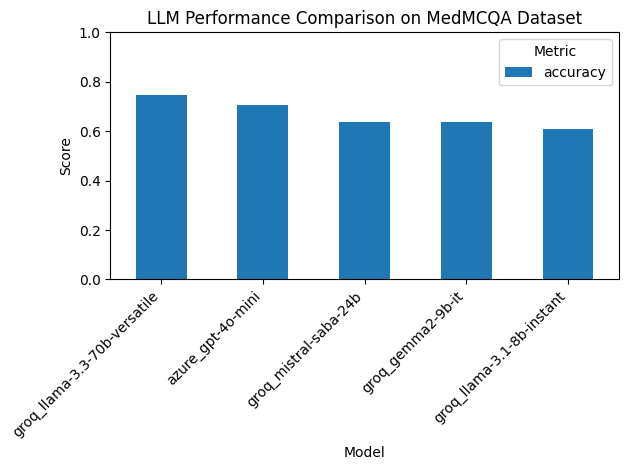

In [17]:
# # Visualize model comparison
plt.figure(figsize=(12,6))
metrics_df[['accuracy']].plot(kind='bar')
plt.title('LLM Performance Comparison on MedMCQA Dataset')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


## 7. Subject-wise Performance Analysis by Model

In [18]:
# Function to calculate subject-wise accuracy for a model
def get_subject_accuracy(results_df):
    return results_df.groupby('subject')['is_correct'].mean().sort_values(ascending=False)

# Get top 5 subjects for each model
for model_key, results_df in results_dfs.items():
    subject_accuracy = get_subject_accuracy(results_df)
    
    print(f"Top 5 subjects for {model_key}:")
    for subject, acc in subject_accuracy.head(5).items():
        count = results_df[results_df['subject'] == subject].shape[0]
        print(f"{subject} ({count} questions): {acc:.2%}")
    print()

Top 5 subjects for azure_gpt-4o-mini:
Biochemistry (5 questions): 100.00%
Microbiology (5 questions): 100.00%
Pediatrics (5 questions): 100.00%
Orthopaedics (5 questions): 80.00%
Dental (5 questions): 80.00%

Top 5 subjects for groq_llama-3.3-70b-versatile:
Skin (5 questions): 100.00%
Physiology (5 questions): 100.00%
Gynaecology & Obstetrics (5 questions): 100.00%
Microbiology (5 questions): 100.00%
Pathology (5 questions): 100.00%

Top 5 subjects for groq_mistral-saba-24b:
Pathology (5 questions): 100.00%
Biochemistry (5 questions): 100.00%
Forensic Medicine (5 questions): 100.00%
Microbiology (5 questions): 100.00%
Orthopaedics (5 questions): 80.00%

Top 5 subjects for groq_llama-3.1-8b-instant:
Pediatrics (5 questions): 100.00%
Orthopaedics (5 questions): 80.00%
Biochemistry (5 questions): 80.00%
Physiology (5 questions): 80.00%
Forensic Medicine (5 questions): 80.00%

Top 5 subjects for groq_gemma2-9b-it:
Biochemistry (5 questions): 100.00%
Forensic Medicine (5 questions): 100.00%

In [19]:
# Compare models on common subjects (subjects with at least 3 questions)
def get_common_subjects(results_dfs, min_questions=3):
    common_subjects = set()
    
    for model_key, results_df in results_dfs.items():
        subject_counts = results_df['subject'].value_counts()
        valid_subjects = subject_counts[subject_counts >= min_questions].index.tolist()
        
        if not common_subjects:
            common_subjects = set(valid_subjects)
        else:
            common_subjects = common_subjects.intersection(valid_subjects)
    
    return list(common_subjects)

common_subjects = get_common_subjects(results_dfs)
print(f"Found {len(common_subjects)} common subjects with at least 3 questions each.")

# Create DataFrame to compare models by subject
subject_comparison = pd.DataFrame(index=common_subjects)

for model_key, results_df in results_dfs.items():
    model_subject_accuracy = {}
    
    for subject in common_subjects:
        subject_df = results_df[results_df['subject'] == subject]
        accuracy = subject_df['is_correct'].mean()
        model_subject_accuracy[subject] = accuracy
    
    subject_comparison[model_key] = pd.Series(model_subject_accuracy)

print("\nModel Accuracy by Subject:")
print(subject_comparison.round(2))

Found 20 common subjects with at least 3 questions each.

Model Accuracy by Subject:
                              azure_gpt-4o-mini  groq_llama-3.3-70b-versatile  \
Physiology                                  0.6                           1.0   
Ophthalmology                               0.6                           0.4   
Pathology                                   0.8                           1.0   
Skin                                        0.8                           1.0   
Orthopaedics                                0.8                           0.8   
Social & Preventive Medicine                0.6                           0.8   
Radiology                                   0.8                           0.6   
ENT                                         0.6                           0.8   
Dental                                      0.8                           0.4   
Microbiology                                1.0                           1.0   
Pediatrics              

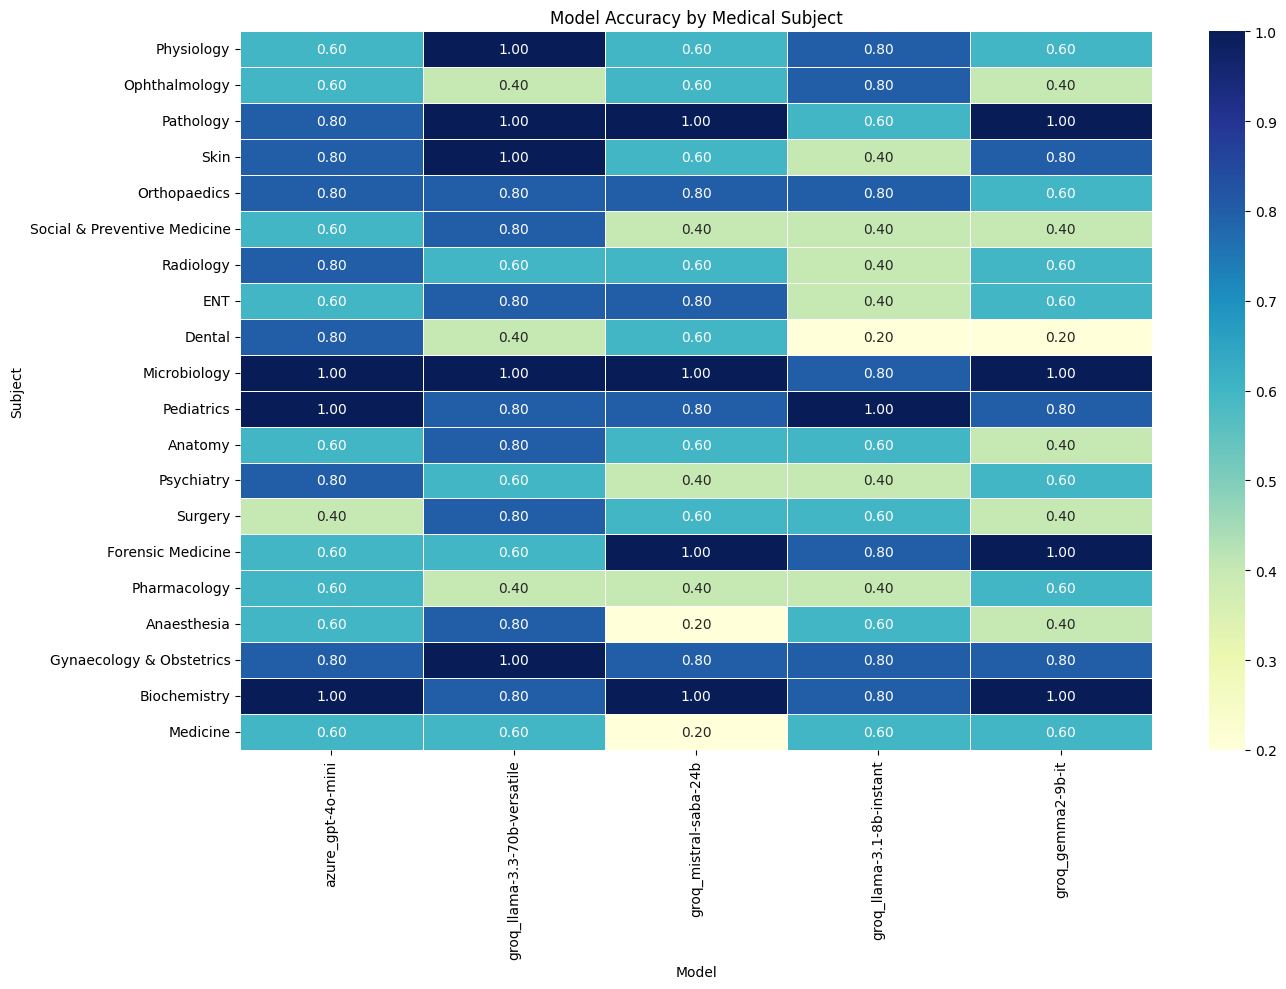

In [20]:
# Visualize subject comparison as a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(subject_comparison, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Model Accuracy by Medical Subject')
plt.ylabel('Subject')
plt.xlabel('Model')
plt.tight_layout()
plt.show()

## 8. Confusion Matrix Analysis for Each Model

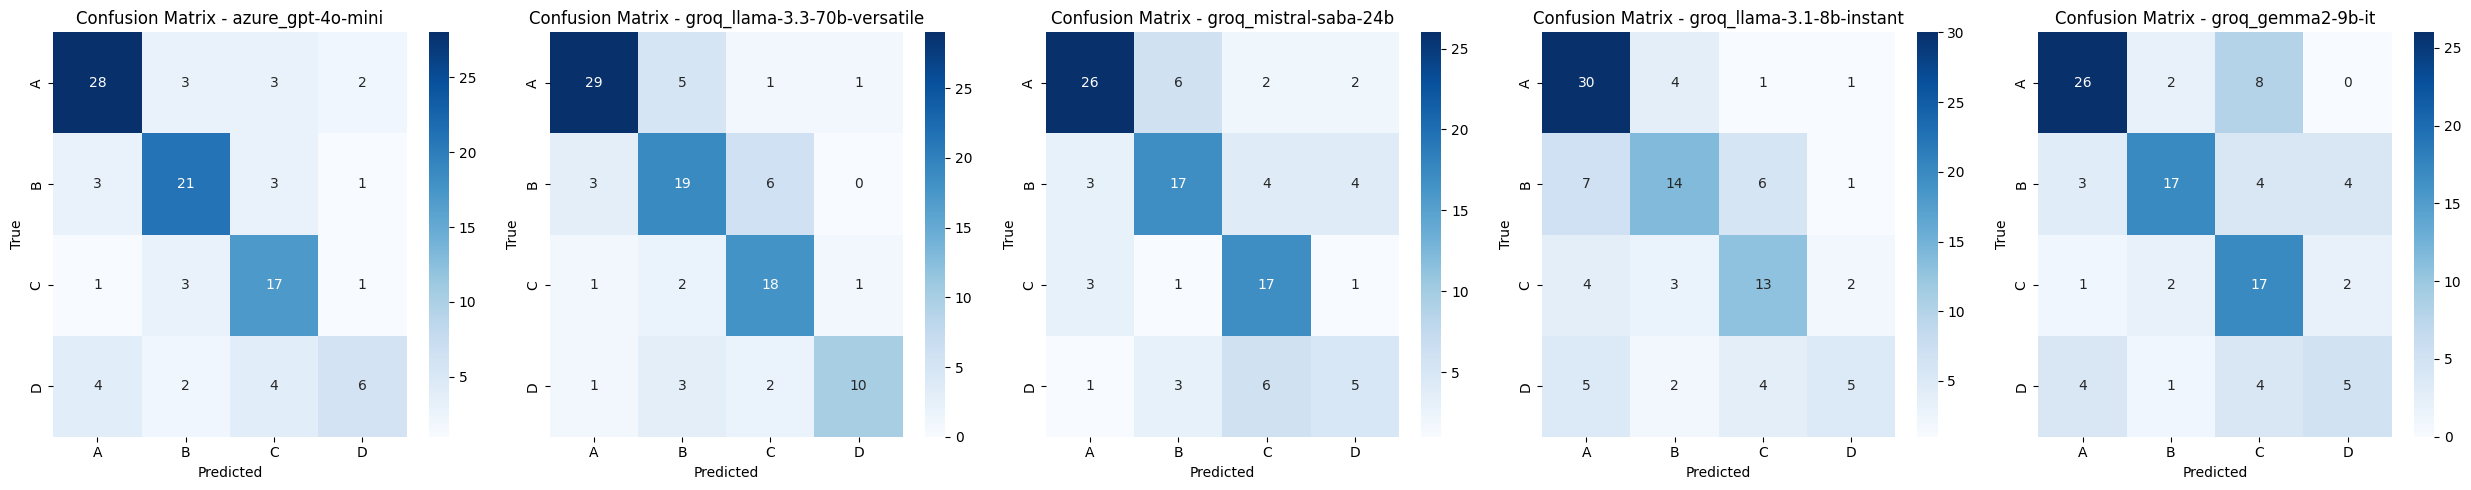

In [21]:
# Create a single figure with confusion matrices for all models
n_models = len(results_dfs)
fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))
if n_models == 1:
    axes = [axes]  # Make it iterable if there's only one model

for i, (model_key, results_df) in enumerate(results_dfs.items()):
    # Filter out any 'Unknown' responses
    valid_results = results_df[results_df['predicted_answer'] != 'Unknown']
    y_true = valid_results['correct_answer']
    y_pred = valid_results['predicted_answer']
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=['A', 'B', 'C', 'D'])
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['A', 'B', 'C', 'D'], 
                yticklabels=['A', 'B', 'C', 'D'],
                ax=axes[i])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
    axes[i].set_title(f'Confusion Matrix - {model_key}')

plt.tight_layout()
plt.show()

## 9. Analysis of Questions with Disagreement Between Models

In [22]:
# Find questions where models disagree
def find_model_disagreements(results_dfs):
    # Get all question IDs
    all_questions = set()
    for results_df in results_dfs.values():
        all_questions.update(results_df['question_id'])
    
    disagreements = []
    
    for qid in all_questions:
        # Get predictions from each model for this question
        predictions = {}
        question_text = ""
        subject = ""
        correct_answer = ""
        
        for model_key, results_df in results_dfs.items():
            q_results = results_df[results_df['question_id'] == qid]
            if not q_results.empty:
                predictions[model_key] = q_results.iloc[0]['predicted_answer']
                question_text = q_results.iloc[0]['question']
                subject = q_results.iloc[0]['subject']
                correct_answer = q_results.iloc[0]['correct_answer']
        
        # Check if there's disagreement
        unique_answers = set(predictions.values())
        if len(unique_answers) > 1 and 'Unknown' not in unique_answers:
            disagreements.append({
                'question_id': qid,
                'question': question_text,
                'subject': subject,
                'correct_answer': correct_answer,
                **predictions
            })
    
    return pd.DataFrame(disagreements)

disagreement_df = find_model_disagreements(results_dfs)
print(f"Found {len(disagreement_df)} questions where models disagreed on the answer.\n")
if not disagreement_df.empty:
    print("Sample disagreements:")
    sample_size = min(5, len(disagreement_df))
    sample_disagreements = disagreement_df.sample(sample_size)
    
    for idx, row in sample_disagreements.iterrows():
        print(f"Question: {row['question']}")
        print(f"Subject: {row['subject']}")
        print(f"Correct Answer: {row['correct_answer']}")
        
        for model_key in [k for k in row.index if k not in ['question_id', 'question', 'subject', 'correct_answer']]:
            print(f"  {model_key}: {row[model_key]}")
        
        print("---")

Found 55 questions where models disagreed on the answer.

Sample disagreements:
Question: All of the following muscles have parallel oriented fibers except:
Subject: Anatomy
Correct Answer: D
  azure_gpt-4o-mini: B
  groq_llama-3.3-70b-versatile: B
  groq_mistral-saba-24b: C
  groq_llama-3.1-8b-instant: A
  groq_gemma2-9b-it: A
---
Question: About depersonalization, which of the following is false:
Subject: Psychiatry
Correct Answer: D
  azure_gpt-4o-mini: D
  groq_llama-3.3-70b-versatile: D
  groq_mistral-saba-24b: D
  groq_llama-3.1-8b-instant: A
  groq_gemma2-9b-it: D
---
Question: Hepatitis B occurs after an incubation period of:
Subject: Medicine
Correct Answer: C
  azure_gpt-4o-mini: C
  groq_llama-3.3-70b-versatile: C
  groq_mistral-saba-24b: B
  groq_llama-3.1-8b-instant: C
  groq_gemma2-9b-it: C
---
Question: Concentric teeth bite mark on forearm, what to do next?
Subject: Forensic Medicine
Correct Answer: C
  azure_gpt-4o-mini: B
  groq_llama-3.3-70b-versatile: B
  groq_mistr

## 10. Save Results for Further Analysis

In [23]:
# Save the results to a CSV file
folder_path=r"C:\Users\lenovo\Desktop\LLM_Evaluation\results\QA\MedMCQA"
os.makedirs(folder_path, exist_ok=True)

for model_key, results_df in results_dfs.items():
    filename = os.path.join(folder_path,f"medical_mcq_evaluation_{model_key}.csv")
    
    results_df.to_csv(filename, index=False)
    print(f"Results for {model_key} saved to '{filename}'")

# Save the metrics comparison
metrics_filename = os.path.join(folder_path, "medical_mcq_evaluation_metrics_comparison.csv")
metrics_df.to_csv(metrics_filename, index=False)
print(f"Metrics comparison saved to '{metrics_filename}'")


# Save the subject comparison
subject_filename = os.path.join(folder_path, "medical_mcq_evaluation_subject_comparison.csv")
subject_comparison.to_csv(subject_filename, index=False)
print(f"Subject comparison saved to '{subject_filename}'")


Results for azure_gpt-4o-mini saved to 'C:\Users\lenovo\Desktop\LLM_Evaluation\results\QA\MedMCQA\medical_mcq_evaluation_azure_gpt-4o-mini.csv'
Results for groq_llama-3.3-70b-versatile saved to 'C:\Users\lenovo\Desktop\LLM_Evaluation\results\QA\MedMCQA\medical_mcq_evaluation_groq_llama-3.3-70b-versatile.csv'
Results for groq_mistral-saba-24b saved to 'C:\Users\lenovo\Desktop\LLM_Evaluation\results\QA\MedMCQA\medical_mcq_evaluation_groq_mistral-saba-24b.csv'
Results for groq_llama-3.1-8b-instant saved to 'C:\Users\lenovo\Desktop\LLM_Evaluation\results\QA\MedMCQA\medical_mcq_evaluation_groq_llama-3.1-8b-instant.csv'
Results for groq_gemma2-9b-it saved to 'C:\Users\lenovo\Desktop\LLM_Evaluation\results\QA\MedMCQA\medical_mcq_evaluation_groq_gemma2-9b-it.csv'
Metrics comparison saved to 'C:\Users\lenovo\Desktop\LLM_Evaluation\results\QA\MedMCQA\medical_mcq_evaluation_metrics_comparison.csv'
Subject comparison saved to 'C:\Users\lenovo\Desktop\LLM_Evaluation\results\QA\MedMCQA\medical_mcq_e

## 11. Conclusion and Summary

In [24]:
print("=== Medical MCQ Evaluation Summary ===")
print(f"Number of questions evaluated: {EVAL_SIZE}")
print(f"Questions per subject: {QUESTIONS_PER_SUBJECT}")
print(f"Number of subjects: {len(eval_df['subject_name'].unique())}")
print("\nModel Performance:")

# Format the metrics nicely for display
for model, metrics in model_metrics.items():
    print(f"\n{model}:")
    print(f"  Accuracy: {metrics['accuracy']:.2%}")
    print(f"  Valid responses: {metrics['valid_responses']}/{metrics['total_questions']}")

# Identify best model for each metric
best_accuracy = metrics_df['accuracy'].idxmax()

print("\nBest performing model by accuracy:", best_accuracy)


# Number of disagreements
if not disagreement_df.empty:
    print(f"\nNumber of questions with model disagreement: {len(disagreement_df)} ({len(disagreement_df)/EVAL_SIZE:.1%} of questions)")

=== Medical MCQ Evaluation Summary ===
Number of questions evaluated: 102
Questions per subject: 5
Number of subjects: 21

Model Performance:

azure_gpt-4o-mini:
  Accuracy: 70.59%
  Valid responses: 102/102

groq_llama-3.3-70b-versatile:
  Accuracy: 74.51%
  Valid responses: 102/102

groq_mistral-saba-24b:
  Accuracy: 63.73%
  Valid responses: 101/102

groq_llama-3.1-8b-instant:
  Accuracy: 60.78%
  Valid responses: 102/102

groq_gemma2-9b-it:
  Accuracy: 63.73%
  Valid responses: 100/102

Best performing model by accuracy: groq_llama-3.3-70b-versatile

Number of questions with model disagreement: 55 (53.9% of questions)
